# MIS 583 Assignment 6: Text Sentiment Classification with Prompt Learning

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷, M114020035

**Your Answer:**   
Hi I'm 鄔仁迪, B104020009

## Overview

**Sentiment Classification** is an automated process of identifying opinions in text and labeling them as positive or negative based on the emotions customers express within them.

In Task 1, you need to fine-tune a pre-trained language model (e.g., BERT) to predict the sentiment of given tweets.

In Task 2, we employ prompts to enable the model to perform sentiment analysis through in-context learning, eliminating the need for additional training.

In Task 3, you will use the method called LM-BFF to utilize the model in generating the optimal template and verbalizer autonomously.


# Notice 
**You are not allow to use the model like GPT family or pre-trained weight using SST-2 and twitter dataset!!!!!!!!!!!!!!!!!**

You can use BERT and RoBERTa encoder model

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.  
We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`.  
This is the default version in Google Colab.

In [1]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]
torch 2.1.0+cu118
torchvision 0.16.0+cu118


# Task 1: Text Sentiment Classification (40 points)

In this task, you need to fine-tune a pre-trained language model (e.g., BERT or RoBERTa encoder) to predict the sentiment of given tweets.


## Loading Model and Data

First, let's talk about the model. The Hugging Face team has created an amazing framework called "transformers" for NLP tasks. It includes many state-of-the-art machine learning models for PyTorch, TensorFlow, and JAX.

To start with this package, follow [this link to installation and a basic tutorial](https://pytorch.org/hub/huggingface_pytorch-transformers/).

In [2]:
# you might need some additional installations there
"""!echo happy installation
!pip -V
!pip install grpcio
!pip install google-auth
!pip install protobuf==3.9.2
!pip install pyprind
!pip install tqdm boto3 requests regex sentencepiece sacremoses"""

'!echo happy installation\n!pip -V\n!pip install grpcio\n!pip install google-auth\n!pip install protobuf==3.9.2\n!pip install pyprind\n!pip install tqdm boto3 requests regex sentencepiece sacremoses'

In [2]:
from torch import nn

#########################################################################
#            Loading tokenizer and model from transformer               #
#########################################################################
from transformers import AutoTokenizer, BertForSequenceClassification, AutoConfig

bert_type = 'bert-base-cased'

# ---------- 1. load from torch.hub ----------
tokenizer = AutoTokenizer.from_pretrained(bert_type)

# create a Bert-extended task (classification)
model = BertForSequenceClassification.from_pretrained(bert_type)

# finetune from the output from bert to your task
model.classifier = nn.Linear(in_features=768, out_features=3, bias=True)
#########################################################################
#                          End of your code                             #
#########################################################################

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## How to Get Data

Please open the file `twitter_sentiment.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `twitter_sentiment.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Unzip Data

解壓縮 `twitter_sentiment.zip` 後可以發現裡面有三個csv檔。

- `train.csv`, `test.csv` and `val.csv`

Training set 有 **10248** 筆資料.  
Validation set 有 **1317** 筆資料.  
Testing set 有 **3075** 筆資料.  

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [4]:
# !unzip -qq ./drive/MyDrive/twitter_sentiment.zip

In [3]:
# Utility function to extract text and label from csv file
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []

    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path, encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [4]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode

        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list

    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

In [5]:
dataset_train = TwitterDataset(mode='train')
dataset_val = TwitterDataset(mode='val')
dataset_test = TwitterDataset(mode='test')

batch_size = 32
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1317 datas
mode test has 3075 datas


In [6]:
t = tokenizer.convert_ids_to_tokens(dataset_train[0][0])
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t))

token ['[CLS]', '@', 'united', 'I', 'have', 'never', 'been', 'mi', '##sle', '##ad', 'by', 'a', 'company', 'as', 'many', 'times', 'as', 'I', 'have', 'this', 'week', 'by', 'United', 'Airlines', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
token to s [CLS] @ united I have never been mislead by a company as many times as I have this week by United Airlines! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [7]:
device = torch.device('cuda')

from torch import nn
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# 定義標籤平滑化的KL損失函數 Paper: https://arxiv.org/pdf/2312.06522.pdf
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = -1

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

# 設定標籤平滑化水平
"""
LS2: smoothing=0.03（即3%平滑化）
LS3: smoothing=0.075（即7.5%平滑化）
LS4: smoothing=0.15（即15%平滑化）
LS5: smoothing=0.3（即30%平滑化）
"""
criterion = LabelSmoothingLoss(classes=3, smoothing=0.3)

model = model.to(device)
criterion = criterion.to(device)

## Utility Function

In [8]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Testing process                              #
        #########################################################################
        # 1. Clean the gradients of optimizer
        # 2. Put correct variables into model
        # 3. Get prediction
        # 4. Evalutate by criterion and accuracy

        # Clean the gradients of optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(text, attention_mask=mask)

        # Compute loss
        loss = criterion(outputs.logits, label)

        # Compute accuracy using the provided function
        acc = accuracy(outputs.logits, label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, criterion, log_loss=False):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Training process                             #
        #########################################################################
        # 1. Put correct variables into model
        # 2. Get prediction
        # 3. Evalutate by criterion and accuracy

        # No gradient calculation for evaluation
        with torch.no_grad():
            # Forward pass
            outputs = model(text, attention_mask=mask)

            # Compute loss
            loss = criterion(outputs.logits, label)

            # Compute accuracy
            acc = accuracy(outputs.logits, label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

# class for monitoring train and test acc/loss
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []

    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)

    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

## Start Training

In [10]:
#########################################################################
#                          Hyper-parameters                             #
#########################################################################
max_epoch = 5
log_interval = 1
best_acc = 0
#########################################################################
#                          End of your code                             #
#########################################################################

m = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    val_loss, val_acc = test(model, val_data, criterion, log_loss=True)

    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))

    m.update(train_loss, train_acc, val_loss, val_acc)

    # model checkpoint
    if val_acc > best_acc:
        best_model = model
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)
        torch.save(model.state_dict(), 'ckpts/e{}.pt'.format(epoch))

100%|██████████| 83/83 [00:03<00:00, 24.39it/s]


Epoch 1 train_loss: 0.030300163535239826 train_acc: 0.7453161592505855
Epoch 1 val_loss:  0.057784445646049946 val_acc : 0.8405466970387244
---------- e 1 save best model ----------


100%|██████████| 83/83 [00:03<00:00, 24.28it/s]


Epoch 2 train_loss: 0.02846814728662616 train_acc: 0.8583138173302107
Epoch 2 val_loss:  0.05745779141930803 val_acc : 0.8451025056947609
---------- e 2 save best model ----------


100%|██████████| 83/83 [00:03<00:00, 24.18it/s]


Epoch 3 train_loss: 0.027747445651835338 train_acc: 0.8985167837626854
Epoch 3 val_loss:  0.057580934615413984 val_acc : 0.8375094912680334


100%|██████████| 83/83 [00:03<00:00, 24.08it/s]


Epoch 4 train_loss: 0.027182757650893893 train_acc: 0.929839968774395
Epoch 4 val_loss:  0.05795935916466159 val_acc : 0.8435839028094153


100%|██████████| 83/83 [00:03<00:00, 23.59it/s]


Epoch 5 train_loss: 0.026730615346111607 train_acc: 0.9547228727556596
Epoch 5 val_loss:  0.057976341736343834 val_acc : 0.853454821564161
---------- e 5 save best model ----------


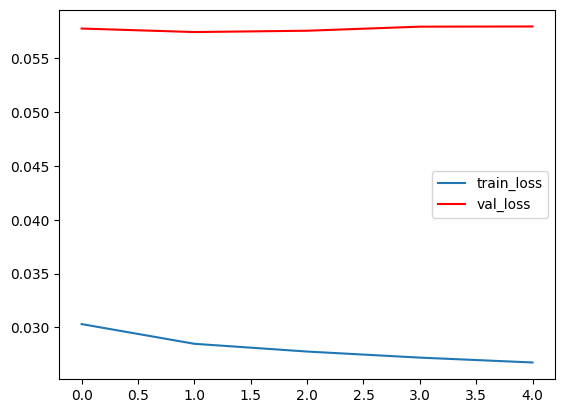

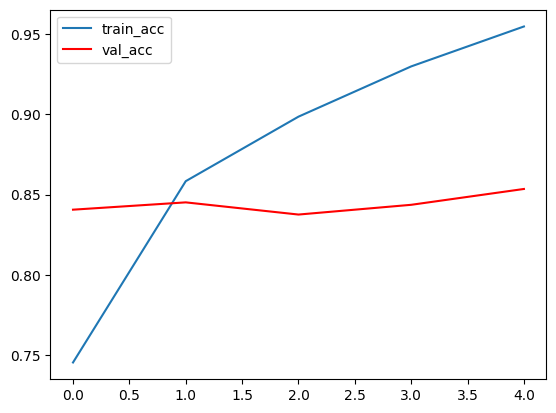

In [11]:
# plot them out
m.plot()

## Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/f072e95f51bc48978225941dba218241).


In [12]:
best_model = model
best_model.load_state_dict(torch.load('ckpts/e2.pt'))

<All keys matched successfully>

In [13]:
best_model.eval()

total_out = []
for text, mask in tqdm(test_data, total=len(test_data)):
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output.logits
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

100%|██████████| 193/193 [00:08<00:00, 23.17it/s]


In [16]:
# Save best model
torch.save(best_model.state_dict(), 'ckpts/bert_model.pt')

# Task 2: In-Context learning (32 points)

In this task, you will learn how to perform sentiment classification using prompts without the need for training.

In [1]:
import torch
import pyprind
import numpy as np
import pandas as pd
import torch.nn as nn
from transformers import BertConfig, BertTokenizer, BertForMaskedLM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Loading model and setup

In [3]:
#########################################################################
#         TODO: Design your own template(prefix) and verbalizer         #
#########################################################################
class Config:
    def __init__(self):
        # Zero-shot learning template
        # self.prefix = "This is [MASK] sentence."
        
        # One-shot learning template
        # self.prefix = (
        #     "This is bad sentence. @united be worse?oh you can't! delayed with no reason on the way to Lon. [SEP] "
        #     "This is [MASK] sentence."
        # )

        # Few-shot learning template
        self.prefix = (
            "This is bad sentence. @united be worse?oh you can't! delayed with no reason on the way to Lon. [SEP] "
            "This is okay sentence. @AmericanAir what's the best number to use? [SEP] "
            "This is good sentence. @JetBlue I was so excited when I saw that you fly there! #ionlyflyblue. [SEP] "
            "This is [MASK] sentence."
        )

        # Define a more comprehensive verbalizer
        self.verbalizer = {
            'bad': 0,
            'okay': 1,
            'good': 2,
        }

        self.max_seq_length = 512
        self.batch_size = 32


config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_type = 'bert-base-uncased'

model = BertForMaskedLM.from_pretrained(bert_type, num_labels=3)

tokenizer = BertTokenizer.from_pretrained(bert_type)

bert_config = BertConfig.from_pretrained(bert_type)

bert = model.from_pretrained(bert_type, config=bert_config).to(device)

#######################################################################
#                        End of your code                             #
#######################################################################

softmax = nn.Softmax(dim=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model t

In [4]:
# Utility function to obtaion verbalizer ids
def obtain_verbalizer_ids(verbalizer, tokenizer):
    verbalizer_ids = tokenizer.convert_tokens_to_ids(list(verbalizer.keys()))
    index2ids = {i: verbalizer_ids[i] for i in range(len(verbalizer_ids))}
    return verbalizer_ids, index2ids

In [5]:
verbalizer_ids, index2ids = obtain_verbalizer_ids(config.verbalizer, tokenizer)

In [6]:
# Utility function to concatenate prefix and text
def concatenate_prefix(texts, config):
    ##################################################
    #   TODO: concatenate your own prefix and text   #                               
    ##################################################
    prefix_texts = [config.prefix + " " + text for text in texts]
    ##################################################
    #                 End of your code               #                               
    ##################################################
    return prefix_texts

In [7]:
def load_data(config):
    # ['texts', 'labels']
    df = pd.read_csv('./twitter_sentiment/train.csv')
    original_texts = df['text'].tolist()
    labels = df['sentiment_label'].tolist()

    texts = concatenate_prefix(original_texts, config)

    return texts, labels


texts, labels = load_data(config)

In [8]:
t = tokenizer.convert_ids_to_tokens(tokenizer.encode(texts[0], add_special_tokens=True))
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t))

token ['[CLS]', 'this', 'is', 'bad', 'sentence', '.', '@', 'united', 'be', 'worse', '?', 'oh', 'you', 'can', "'", 't', '!', 'delayed', 'with', 'no', 'reason', 'on', 'the', 'way', 'to', 'lo', '##n', '.', '[SEP]', 'this', 'is', 'okay', 'sentence', '.', '@', 'americana', '##ir', 'what', "'", 's', 'the', 'best', 'number', 'to', 'use', '?', '[SEP]', 'this', 'is', 'good', 'sentence', '.', '@', 'jet', '##bl', '##ue', 'i', 'was', 'so', 'excited', 'when', 'i', 'saw', 'that', 'you', 'fly', 'there', '!', '#', 'ion', '##ly', '##fly', '##bl', '##ue', '.', '[SEP]', 'this', 'is', '[MASK]', 'sentence', '.', '@', 'united', 'i', 'have', 'never', 'been', 'mis', '##lea', '##d', 'by', 'a', 'company', 'as', 'many', 'times', 'as', 'i', 'have', 'this', 'week', 'by', 'united', 'airlines', '!', '[SEP]']
token to s [CLS] this is bad sentence . @ united be worse ? oh you can ' t ! delayed with no reason on the way to lon . [SEP] this is okay sentence . @ americanair what ' s the best number to use ? [SEP] this is

In [9]:
# Batching of texts and labels for training or processing in batches
def pack_batch(texts, labels, batch_size):
    """
    :param texts: list
    :param labels: list
    :param batch_size: int
    :return batch_X: list
            [[text11, text12, ...], [text21, text22, ...], ...]
    :return batch_y: list
            [[label11, label12, ...], [label21, label22, ...], ...]
    :return batch_count: int
    """
    assert len(texts) == len(labels)

    if len(texts) % batch_size != 0:
        flag = False
        batch_count = int(len(texts) / batch_size) + 1
    else:
        flag = True
        batch_count = int(len(texts) / batch_size)

    batch_X, batch_y = [], []

    if flag:
        for i in range(batch_count):
            batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
            batch_y.append(labels[i * batch_size: (i + 1) * batch_size])
    else:
        for i in range(batch_count):
            if i == batch_count - 1:
                batch_X.append(texts[i * batch_size:])
                batch_y.append(labels[i * batch_size:])
            else:
                batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
                batch_y.append(labels[i * batch_size: (i + 1) * batch_size])

    return batch_X, batch_y, batch_count

In [10]:
batch_X, batch_y, batch_count = pack_batch(texts, labels, config.batch_size)

In [11]:
with torch.no_grad():
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    pper = pyprind.ProgPercent(batch_count)
    for i in range(batch_count):
        inputs = batch_X[i]
        labels = batch_y[i]

        tokens = tokenizer.batch_encode_plus(inputs, add_special_tokens=True,
                                             max_length=config.max_seq_length,
                                             padding='max_length', truncation=True)
        
        ids = torch.tensor(tokens['input_ids']).to(device)
        attention_mask = torch.tensor(tokens['attention_mask']).to(device)

        # Shape: (batch_size, max_seq_length, vocab_size)
        logits = bert(ids, attention_mask=attention_mask).logits

        mask_token_index = (ids == tokenizer.mask_token_id).nonzero(as_tuple=True)

        # Find [MASK] logits
        # shape: (batch_size, vocab_size)
        masked_logits = logits[mask_token_index[0], mask_token_index[1], :]

        # Extract the logits of the word in the verbalizer at the [MASK] position
        # shape: (batch_size, verbalizer_size)
        verbalizer_logits = masked_logits[:, verbalizer_ids]

        # Construct a pseudo-distribution from the logits in these verbalizers
        pseudo_distribution = softmax(verbalizer_logits)

        #################################################################################
        #   1. Find the index with the maximum probability in the pseudo-distribution   #
        #   2. Convert the index to the corresponding word ID                           #
        #   3. Convert the ID to a token                                                #
        #   4. Find the label corresponding to the token                                #
        #################################################################################
        # 1. Find the index with the maximum probability in the pseudo-distribution
        pred_indices = torch.argmax(pseudo_distribution, dim=1)

        # 2. Convert the index to the corresponding word ID
        pred_ids = [verbalizer_ids[index] for index in pred_indices]

        # 3. Convert the ID to a token
        pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids)

        # 4. Find the label corresponding to the token
        pred_labels = [config.verbalizer[token] if token in config.verbalizer else -1 for token in pred_tokens]
        pred_labels = np.array(pred_labels)
        #################################################################################
        #                             End of your code                                  #                                       
        #################################################################################

        predict_all = np.append(predict_all, pred_labels)
        labels_all = np.append(labels_all, labels)

        pper.update()

    acc = accuracy_score(labels_all, predict_all)
    p = precision_score(labels_all, predict_all, average="weighted")
    r = recall_score(labels_all, predict_all, average="weighted")
    f1 = f1_score(labels_all, predict_all, average="weighted")

    print('accuracy: %f | precision: %f | recall: %f | f1: %f' % (acc, p, r, f1))

[100 %] Time elapsed: 00:06:04 | ETA: 00:00:00

accuracy: 0.348946 | precision: 0.654360 | recall: 0.348946 | f1: 0.363316



Total time elapsed: 00:06:04


# Task 3: LM-BFF (45 points)

https://arxiv.org/pdf/2012.15723.pdf

Unlike the previous task, LM-BFF can generate templates and verbalizers automatically.

# Get Data

請先到共用雲端硬碟將檔案 `SST-2.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/14MDYFasXU94dUE9DjgfcZE61iTRI2007/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

# Install openprompt

In [1]:
# !pip install openprompt

     ---------------------------------------- 0.0/146.4 kB ? eta -:--:--
     ---------------- ---------------------- 61.4/146.4 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 146.4/146.4 kB 1.7 MB/s eta 0:00:00
  Obtaining dependency information for transformers>=4.10.0 from https://files.pythonhosted.org/packages/12/dd/f17b11a93a9ca27728e12512d167eb1281c151c4c6881d3ab59eb58f4127/transformers-4.35.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/123.5 kB ? eta -:--:--
     -------------------------------------- 123.5/123.5 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---- ----------------------------------- 0.1/1.1 MB 2.2 MB/s eta 0:00:01
     ------ --------------------------------- 0.2/1.1 MB 2.1 MB/s eta 0:00:01
     ---------- ----------------------------- 0.3/1.1 MB 2.0 MB/s eta 0:00:01
     ------------- -------------------------- 0.4/1.1 MB 2.1 MB/s eta 0:00:01
     --------


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\eddie\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


# Import openprompt package

In [1]:
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from transformers import  AdamW, get_linear_schedule_with_warmup
import numpy as np

C:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [2]:
cuda = True
auto_t = True # Whether to perform automatic template generation
auto_v = True # Whether to perform automatic verbalizer generation

# Load dataset and model

In [3]:
from openprompt.data_utils.text_classification_dataset import SST2Processor
dataset = {'train': SST2Processor().get_train_examples("SST-2/"),
           'validation': SST2Processor().get_dev_examples("SST-2/"),
           'test': SST2Processor().get_test_examples("SST-2/")}

In [4]:
#print('load model...')
from openprompt.plms import load_plm
# load mlm model for main tasks
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "roberta-large")

# load generation model for template generation
template_generate_model, template_generate_tokenizer, template_generate_model_config, template_tokenizer_wrapper = load_plm('t5', 't5-large')

from openprompt.prompts import ManualVerbalizer, ManualTemplate
verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['terrible','great'])


###################################################################################################################
#   TODO: You need to switch LMBFFTemplateGenerationTemplate or ManualTemplate to                                 #
#         compare auto generate template and manual generate template                                             #
###################################################################################################################
from openprompt.prompts.prompt_generator import LMBFFTemplateGenerationTemplate
########################################
#   LMBFFTemplateGenerationTemplate    #
########################################
import random

# number of demonstrations
num_demonstrations = 1  # try different number

demonstrations = []

for _ in range(num_demonstrations):
    # random choice training set example with label 0 
    random_example_1 = random.choice([example for example in dataset['train'] if example.label == 0])

    # random choice training set example with label 1
    random_example_2 = random.choice([example for example in dataset['train'] if example.label == 1])
    
    demonstration = f'{random_example_1.text_a} It was terrible. {random_example_2.text_a} It was great.'
    demonstrations.append(demonstration)

# You can modify the demonstrations and try different combinations
template_text = '{"placeholder": "text_a"} {"mask"} {"meta": "labelword"} {"mask"}.' + ' '.join(demonstrations)
template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)

#############################################
#   End of LMBFFTemplateGenerationTemplate  #
#############################################

########################################
#          ManualTemplate              #
########################################

#template = ManualTemplate(tokenizer=tokenizer, text='{"placeholder":"text_a"} It was {"mask"}.')

#############################################
#          End of ManualTemplate            # 
#############################################

###################################################################################################################
#                                           End of your code                                                      #
###################################################################################################################


# view wrapped example
wrapped_example = template.wrap_one_example(dataset['train'][0])
print("dataset:", dataset['train'][0])

C:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\t5\tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing change

dataset: {
  "guid": "train-0",
  "label": 0,
  "meta": {
    "labelword": "terrible"
  },
  "text_a": "nothing happens , and it happens to flat characters .",
  "text_b": "",
  "tgt_text": null
}



# Utility Function

In [5]:
import inspect
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from torch.optim import AdamW
from transformers import  get_linear_schedule_with_warmup
import numpy as np

# Returns the best evaluation score achieved during training
def fit(model, train_dataloader, val_dataloader, loss_func, optimizer, epochs=5):
    best_score = 0.0
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_dataloader, loss_func, optimizer)
        score = evaluate(model, val_dataloader)
        if score > best_score:
            best_score = score
        print(f"Epoch {epoch+1}: Train loss={train_loss}, Eval score={score}")
    return best_score

# Trains the model on the training data and computes the training loss
def train_epoch(model, train_dataloader, loss_func, optimizer):
    model.train()
    loss_all = []
    for step, inputs in enumerate(train_dataloader):
        if cuda:
            inputs = inputs.cuda()
        #####################################################
        # 1. Put correct variables into model to get logits #
        # 2. Get labels                                     #
        # 3. Evalutate using loss_func                      #
        # 4. Append loss to loss_all                        #
        #####################################################
        # 1. Put correct variables into model to get logits
        logits = model(batch=inputs)

        # 2. Get labels
        labels = inputs['label']

        # 3. Evalutate using loss_func
        loss = loss_func(logits, labels)
        loss.backward()

        # 4. Append loss to loss_all
        loss_all.append(loss.item())
        #####################################################
        #                 End of your code                  #
        #####################################################
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(loss_all)

def evaluate(model, val_dataloader):
    model.eval()
    allpreds = []
    alllabels = []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if cuda:
                inputs = inputs.cuda()
            #####################################################
            # 1. Put correct variables into model to get logits #
            # 2. Get labels                                     #
            # 3. Extend labels to list                          #
            # 4. Get predictions and extend preds to list       #
            #####################################################
            # 1. Put correct variables into model to get logits
            logits = model(batch=inputs)

            # 2. Get labels
            labels = inputs['label']

            # 3. Extend labels to list
            alllabels.extend(labels.cpu().numpy())

            # 4. Get predictions and extend preds to list
            preds = torch.argmax(logits, dim=1)
            allpreds.extend(preds.cpu().numpy())
            #####################################################
            #                 End of your code                  #
            #####################################################
    acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
    return acc

# Template generation

generated template from TemplateGenerator and find the best template 

In [6]:
from tqdm import tqdm

class ManualTemplateWithoutParse(ManualTemplate):
    """The generated template from TemplateGenerator is a list of dict of parsed template_text. So no further parsing is needed."""
    def on_text_set(self):
        pass

# Template generation
if auto_t:
    print('performing auto_t...')

    if cuda:
        template_generate_model = template_generate_model.cuda()
    template_generator = T5TemplateGenerator(template_generate_model, template_generate_tokenizer, template_tokenizer_wrapper, verbalizer, beam_width=5) # Beam_width is set to 5 here for efficiency; to improve performance, try a larger number.


    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=template_generate_tokenizer, tokenizer_wrapper_class=template_tokenizer_wrapper, batch_size=len(dataset['train']), decoder_max_length=128, max_seq_length=128, shuffle=False, teacher_forcing=False) # Register all data at once
    for data in dataloader:
        if cuda:
            data = data.cuda()
        template_generator._register_buffer(data)

    template_generate_model.eval()
    print('generating...')
    template_texts = template_generator._get_templates()

    original_template = template.text
    template_texts = [template_generator.convert_template(template_text, original_template) for template_text in template_texts]
    # template_generator._show_template()
    template_generator.release_memory()
    # Generate a number of candidate template text
    print(template_texts)
    
    # Iterate over each candidate and select the best one
    best_metrics = 0.0
    best_template_text = None
    for template_text in tqdm(template_texts):
        verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['terrible','great'])
        template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
        print(f"Current template: {template_text}\n\nWrapped example: {template.wrap_one_example(dataset['train'][0])}")

        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)
        
        #######################################################
        # TODO: Use score to Find your best template_text     #
        #######################################################
        if score > best_metrics:
            best_metrics = score
            best_template_text = template_text
        #######################################################
        #                 End of your code                    #
        #######################################################
    # Use the best template
    verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['terrible','great'])
    template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=best_template_text)
    print("Final best template:", best_template_text)
    print()
    print("Wrapped example:", template.wrap_one_example(dataset["train"][0]))

performing auto_t...


tokenizing: 32it [00:00, 1454.57it/s]


generating...


100%|██████████| 18/18 [00:37<00:00,  2.07s/it]


['{"placeholder": "text_a"} It was {"mask"} ..the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', '{"placeholder": "text_a"} it was {"mask"} ..the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', '{"placeholder": "text_a"} A {"mask"} film.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', '{"placeholder": "text_a"} It was {"mask"} . It was terrible.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall 

  0%|          | 0/5 [00:00<?, ?it/s]

Current template: {"placeholder": "text_a"} It was {"mask"} ..the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': ' ..the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 0it [00:00, ?it/s]
tokenizing: 32it [00:00, 202.53it/s]A

tokenizing: 32it [00:00, 727.28it/s]


Epoch 1: Train loss=2.562330920593297, Eval score=0.5
Epoch 2: Train loss=1.029085214715451, Eval score=0.5
Epoch 3: Train loss=0.671642615867313, Eval score=0.71875
Epoch 4: Train loss=0.2566610455396585, Eval score=0.6875


 20%|██        | 1/5 [15:59<1:03:57, 959.36s/it]

Epoch 5: Train loss=0.2469192902863142, Eval score=0.78125
Current template: {"placeholder": "text_a"} it was {"mask"} ..the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' it was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': ' ..the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 379.37it/s]

tokenizing: 32it [00:00, 1142.92it/s]


Epoch 1: Train loss=1.511358927668084, Eval score=0.5
Epoch 2: Train loss=0.7635227439459413, Eval score=0.5
Epoch 3: Train loss=0.3154368309772053, Eval score=0.53125
Epoch 4: Train loss=0.8977778584977472, Eval score=0.53125


 40%|████      | 2/5 [36:43<56:21, 1127.10s/it] 

Epoch 5: Train loss=0.7606429383413342, Eval score=0.5
Current template: {"placeholder": "text_a"} A {"mask"} film.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' A', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': ' film.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 571.42it/s]

tokenizing: 32it [00:00, 1180.54it/s]


Epoch 1: Train loss=1.765889931773188, Eval score=0.71875
Epoch 2: Train loss=0.5693292848736746, Eval score=0.78125
Epoch 3: Train loss=0.041312409681268036, Eval score=0.84375
Epoch 4: Train loss=0.2322409824218994, Eval score=0.84375


 60%|██████    | 3/5 [56:36<38:33, 1156.92s/it]

Epoch 5: Train loss=0.22881872234574985, Eval score=0.84375
Current template: {"placeholder": "text_a"} It was {"mask"} . It was terrible.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': ' . It was terrible.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 1066.65it/s]

tokenizing: 32it [00:00, 1523.90it/s]


Epoch 1: Train loss=1.7746381501195, Eval score=0.5
Epoch 2: Train loss=0.9883591458201408, Eval score=0.5
Epoch 3: Train loss=0.8319057337939739, Eval score=0.625
Epoch 4: Train loss=0.508084288907412, Eval score=0.75


 80%|████████  | 4/5 [1:16:21<19:27, 1167.97s/it]

Epoch 5: Train loss=0.39746711112820776, Eval score=0.53125
Current template: {"placeholder": "text_a"} It was {"mask"} . It was horrible.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': ' . It was horrible.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 864.68it/s]

tokenizing: 32it [00:00, 1454.78it/s]


Epoch 1: Train loss=1.6042319842349002, Eval score=0.5
Epoch 2: Train loss=1.069442194304429, Eval score=0.5
Epoch 3: Train loss=0.47684725234284997, Eval score=0.6875
Epoch 4: Train loss=0.2768472472046142, Eval score=0.59375


100%|██████████| 5/5 [1:36:08<00:00, 1153.77s/it]

Epoch 5: Train loss=0.07557142606344769, Eval score=0.625
Final best template: {"placeholder": "text_a"} A {"mask"} film.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' A', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': ' film.the big finish is a bit like getting all excited about a chocolate eclair and then biting into it and finding the filling missing . It was terrible. a film that will enthrall the whole family . It was great.', 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]


# Verbalizer generation

verbalizer template from VerbalizerGenerator and find the best verbalizer

In [7]:
# Verbalizer generation
from openprompt.prompts.prompt_generator import RobertaVerbalizerGenerator
if auto_v:
    print('performing auto_v...')
    # Load generation model for verbalizer generation
    if cuda:
        plm = plm.cuda()
    verbalizer_generator = RobertaVerbalizerGenerator(model=plm, tokenizer=tokenizer, candidate_num=20, label_word_num_per_class=20)
    # To improve performance, try larger numbers

    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, batch_size=32)
    for data in dataloader:
        if cuda:
            data = data.cuda()
        verbalizer_generator.register_buffer(data)
    label_words_list = verbalizer_generator.generate()
    verbalizer_generator.release_memory()

    # Iterate over each candidate and select the best one
    current_verbalizer = copy.deepcopy(verbalizer)
    best_metrics = 0.0
    best_label_words = None
    for label_words in tqdm(label_words_list):
        print(f"current label_words: {label_words}")
        current_verbalizer.label_words = label_words
        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, current_verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

        #######################################################
        # TODO: Use score to find your best_label_word        #
        #######################################################
        if score > best_metrics:
            best_metrics = score
            best_label_words = label_words
        #######################################################
        #                 End of your code                    #
        #######################################################
    # use the best verbalizer
    print("final best label words:", best_label_words)
    verbalizer = ManualVerbalizer(tokenizer, num_classes=2, label_words=best_label_words)

performing auto_v...


tokenizing: 32it [00:00, 1391.30it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

current label_words: ['terrible', 'beautiful']



tokenizing: 0it [00:00, ?it/s]
tokenizing: 3it [00:00, 21.48it/s]
tokenizing: 6it [00:01,  5.15it/s]
tokenizing: 8it [00:01,  6.27it/s]
tokenizing: 32it [00:01, 23.45it/s]

tokenizing: 32it [00:00, 969.52it/s]


Epoch 1: Train loss=2.1593105591260544, Eval score=0.59375
Epoch 2: Train loss=0.5407680265489034, Eval score=0.8125
Epoch 3: Train loss=0.17979280870349612, Eval score=0.8125
Epoch 4: Train loss=0.006995583800744498, Eval score=0.84375


  5%|▌         | 1/20 [21:05<6:40:40, 1265.26s/it]

Epoch 5: Train loss=0.002051841642924046, Eval score=0.84375
current label_words: ['horrible', 'fascinating']



tokenizing: 32it [00:00, 695.63it/s]

tokenizing: 32it [00:00, 1388.63it/s]


Epoch 1: Train loss=1.5843039118335565, Eval score=0.84375
Epoch 2: Train loss=0.0798521326687478, Eval score=0.78125
Epoch 3: Train loss=0.0026221817748819376, Eval score=0.78125
Epoch 4: Train loss=0.0010607897513068565, Eval score=0.78125


 10%|█         | 2/20 [42:02<6:18:07, 1260.40s/it]

Epoch 5: Train loss=0.0004625524882726495, Eval score=0.78125
current label_words: ['horrible', 'superb']



tokenizing: 32it [00:00, 762.07it/s]

tokenizing: 32it [00:00, 1333.19it/s]


Epoch 1: Train loss=2.0936600251085586, Eval score=0.71875
Epoch 2: Train loss=0.849827597849071, Eval score=0.8125
Epoch 3: Train loss=0.414547988853883, Eval score=0.75
Epoch 4: Train loss=0.0500250239797424, Eval score=0.8125


 15%|█▌        | 3/20 [1:02:46<5:55:04, 1253.18s/it]

Epoch 5: Train loss=0.004471211226245941, Eval score=0.8125
current label_words: ['sad', 'perfect']



tokenizing: 32it [00:00, 415.60it/s]

tokenizing: 32it [00:00, 941.24it/s]


Epoch 1: Train loss=1.4185917818103917, Eval score=0.8125
Epoch 2: Train loss=0.5065413688316767, Eval score=0.875
Epoch 3: Train loss=0.012464412650388113, Eval score=0.875
Epoch 4: Train loss=0.002708091426967485, Eval score=0.84375


 20%|██        | 4/20 [1:23:35<5:33:44, 1251.51s/it]

Epoch 5: Train loss=0.0004699288858773798, Eval score=0.875
current label_words: ['bad', 'superb']



tokenizing: 32it [00:00, 551.73it/s]

tokenizing: 32it [00:00, 1066.52it/s]


Epoch 1: Train loss=3.1230944280390602, Eval score=0.5
Epoch 2: Train loss=1.270681380527094, Eval score=0.5
Epoch 3: Train loss=0.8551086119841784, Eval score=0.65625
Epoch 4: Train loss=0.6224154182709754, Eval score=0.6875


 25%|██▌       | 5/20 [1:45:07<5:16:30, 1266.02s/it]

Epoch 5: Train loss=0.22766433987999335, Eval score=0.8125
current label_words: ['horrible', 'remarkable']



tokenizing: 32it [00:00, 426.62it/s]

tokenizing: 32it [00:00, 1031.99it/s]


Epoch 1: Train loss=2.2276666148868003, Eval score=0.6875
Epoch 2: Train loss=0.4889321715090773, Eval score=0.71875
Epoch 3: Train loss=0.2634941844644345, Eval score=0.6875
Epoch 4: Train loss=0.25736280560994373, Eval score=0.75


 30%|███       | 6/20 [2:07:36<5:01:58, 1294.20s/it]

Epoch 5: Train loss=0.3903749104914027, Eval score=0.625
current label_words: ['terrible', 'brilliant']



tokenizing: 32it [00:00, 493.33it/s]

tokenizing: 32it [00:00, 1066.39it/s]


Epoch 1: Train loss=2.128300400949797, Eval score=0.5
Epoch 2: Train loss=1.0674331626432831, Eval score=0.6875
Epoch 3: Train loss=0.6011688623111695, Eval score=0.875
Epoch 4: Train loss=0.6810656589186692, Eval score=0.75


 35%|███▌      | 7/20 [2:28:49<4:38:53, 1287.20s/it]

Epoch 5: Train loss=0.1570308672144165, Eval score=0.84375
current label_words: ['terrible', 'terrific']



tokenizing: 32it [00:00, 451.65it/s]

tokenizing: 32it [00:00, 1033.03it/s]


Epoch 1: Train loss=1.1662085960851982, Eval score=0.84375
Epoch 2: Train loss=0.046194135922632995, Eval score=0.78125
Epoch 3: Train loss=0.20158991879031873, Eval score=0.84375
Epoch 4: Train loss=0.009880203132524912, Eval score=0.65625


 40%|████      | 8/20 [2:51:16<4:21:16, 1306.40s/it]

Epoch 5: Train loss=0.27703922392970526, Eval score=0.90625
current label_words: ['disappointing', 'perfect']



tokenizing: 32it [00:00, 415.57it/s]

tokenizing: 32it [00:00, 1032.29it/s]


Epoch 1: Train loss=1.3897865504303581, Eval score=0.71875
Epoch 2: Train loss=0.6985758165101288, Eval score=0.5625
Epoch 3: Train loss=0.20094251398768392, Eval score=0.875
Epoch 4: Train loss=0.021359096241212683, Eval score=0.90625


 45%|████▌     | 9/20 [3:11:17<3:53:28, 1273.48s/it]

Epoch 5: Train loss=0.0014102687238164435, Eval score=0.90625
current label_words: ['strange', 'fascinating']



tokenizing: 32it [00:00, 410.23it/s]

tokenizing: 32it [00:00, 1142.62it/s]


Epoch 1: Train loss=1.4916955009493904, Eval score=0.5
Epoch 2: Train loss=0.5601507005485473, Eval score=0.8125
Epoch 3: Train loss=0.050391235166898696, Eval score=0.78125
Epoch 4: Train loss=0.04447055474645367, Eval score=0.71875


 50%|█████     | 10/20 [3:31:10<3:28:06, 1248.60s/it]

Epoch 5: Train loss=0.5673459974156145, Eval score=0.78125
current label_words: ['terrible', 'good']



tokenizing: 32it [00:00, 363.21it/s]

tokenizing: 32it [00:00, 1066.59it/s]


Epoch 1: Train loss=1.9351653824437118, Eval score=0.5
Epoch 2: Train loss=0.9128216816243366, Eval score=0.78125
Epoch 3: Train loss=0.16854792425147025, Eval score=0.84375
Epoch 4: Train loss=0.004711857527581742, Eval score=0.84375


 55%|█████▌    | 11/20 [3:50:34<3:03:23, 1222.60s/it]

Epoch 5: Train loss=0.0015127657302400621, Eval score=0.84375
current label_words: ['bad', 'perfect']



tokenizing: 32it [00:00, 524.59it/s]

tokenizing: 32it [00:00, 1142.77it/s]


Epoch 1: Train loss=2.8022562539517715, Eval score=0.5
Epoch 2: Train loss=0.9302898038731655, Eval score=0.6875
Epoch 3: Train loss=0.43625156552297994, Eval score=0.8125
Epoch 4: Train loss=0.04196147369020764, Eval score=0.71875


 60%|██████    | 12/20 [4:10:06<2:40:57, 1207.20s/it]

Epoch 5: Train loss=0.012102704274127518, Eval score=0.65625
current label_words: ['short', 'superb']



tokenizing: 32it [00:00, 412.44it/s]

tokenizing: 32it [00:00, 1203.38it/s]


Epoch 1: Train loss=1.8797737168388267, Eval score=0.75
Epoch 2: Train loss=0.3757321042244257, Eval score=0.71875
Epoch 3: Train loss=0.2311989847357836, Eval score=0.65625
Epoch 4: Train loss=0.43366863449273296, Eval score=0.71875


 65%|██████▌   | 13/20 [4:30:04<2:20:30, 1204.31s/it]

Epoch 5: Train loss=0.620734619528541, Eval score=0.59375
current label_words: ['disappointing', 'delightful']



tokenizing: 32it [00:00, 426.69it/s]

tokenizing: 32it [00:00, 1143.18it/s]


Epoch 1: Train loss=2.324861448905718, Eval score=0.59375
Epoch 2: Train loss=0.5381804386270232, Eval score=0.5625
Epoch 3: Train loss=0.36967586419450527, Eval score=0.84375
Epoch 4: Train loss=0.12384688404563349, Eval score=0.75


 70%|███████   | 14/20 [4:49:18<1:58:55, 1189.18s/it]

Epoch 5: Train loss=0.18691727038913086, Eval score=0.6875
current label_words: ['bad', 'brilliant']



tokenizing: 32it [00:00, 490.61it/s]

tokenizing: 32it [00:00, 1103.17it/s]


Epoch 1: Train loss=2.5005056243027184, Eval score=0.5625
Epoch 2: Train loss=0.7745201710495166, Eval score=0.875
Epoch 3: Train loss=0.13810731278863386, Eval score=0.8125
Epoch 4: Train loss=0.004411970109288177, Eval score=0.8125


 75%|███████▌  | 15/20 [5:08:29<1:38:08, 1177.73s/it]

Epoch 5: Train loss=0.00313117326692236, Eval score=0.78125
current label_words: ['bad', 'terrific']



tokenizing: 32it [00:00, 492.79it/s]

tokenizing: 32it [00:00, 1066.65it/s]


Epoch 1: Train loss=2.182302282977588, Eval score=0.5
Epoch 2: Train loss=0.5332906207768247, Eval score=0.6875
Epoch 3: Train loss=0.08191546555644891, Eval score=0.65625
Epoch 4: Train loss=0.35411459776105403, Eval score=0.625


 80%|████████  | 16/20 [5:26:58<1:17:08, 1157.03s/it]

Epoch 5: Train loss=0.13951104862388775, Eval score=0.46875
current label_words: ['horrible', 'perfect']



tokenizing: 32it [00:00, 466.99it/s]

tokenizing: 32it [00:00, 1219.88it/s]


Epoch 1: Train loss=1.4121702450024713, Eval score=0.5625
Epoch 2: Train loss=0.32750329683221935, Eval score=0.90625
Epoch 3: Train loss=0.01347528245059948, Eval score=0.90625
Epoch 4: Train loss=0.3011642301885331, Eval score=0.84375


 85%|████████▌ | 17/20 [5:45:44<57:23, 1147.77s/it]  

Epoch 5: Train loss=0.022153147599055956, Eval score=0.875
current label_words: ['fine', 'remarkable']



tokenizing: 32it [00:00, 492.08it/s]

tokenizing: 32it [00:00, 1185.16it/s]


Epoch 1: Train loss=1.7259275259780793, Eval score=0.5
Epoch 2: Train loss=0.7986743192886934, Eval score=0.65625
Epoch 3: Train loss=0.6269949703128077, Eval score=0.5
Epoch 4: Train loss=0.16056611831118062, Eval score=0.75


 90%|█████████ | 18/20 [6:04:43<38:10, 1145.06s/it]

Epoch 5: Train loss=0.003870869544044808, Eval score=0.78125
current label_words: ['disappointing', 'fascinating']



tokenizing: 32it [00:00, 454.61it/s]

tokenizing: 32it [00:00, 1183.92it/s]


Epoch 1: Train loss=1.4480454477061357, Eval score=0.5
Epoch 2: Train loss=0.8791331336833537, Eval score=0.8125
Epoch 3: Train loss=0.4247932309117459, Eval score=0.6875
Epoch 4: Train loss=0.2258107879970339, Eval score=0.6875


 95%|█████████▌| 19/20 [6:23:21<18:56, 1137.00s/it]

Epoch 5: Train loss=0.0734178872121447, Eval score=0.875
current label_words: ['terrible', 'fine']



tokenizing: 32it [00:00, 489.28it/s]

tokenizing: 32it [00:00, 1164.44it/s]


Epoch 1: Train loss=1.6715138442009447, Eval score=0.8125
Epoch 2: Train loss=0.6137157797584223, Eval score=0.6875
Epoch 3: Train loss=0.38552796499482156, Eval score=0.875
Epoch 4: Train loss=0.34600197029577373, Eval score=0.65625


100%|██████████| 20/20 [6:41:58<00:00, 1205.94s/it]

Epoch 5: Train loss=0.6120385159649686, Eval score=0.78125
final best label words: ['terrible', 'terrific']


In [8]:
train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)
test_dataloader = PromptDataLoader(dataset['test'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)


model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
# It's always good practice to set no decay to bias and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
if cuda:
    model = model.cuda()
score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

tokenizing: 32it [00:00, 383.01it/s]
tokenizing: 32it [00:00, 1142.78it/s]
tokenizing: 872it [00:00, 1095.80it/s]


Epoch 1: Train loss=1.2980121186483302, Eval score=0.8125
Epoch 2: Train loss=0.38737686289732665, Eval score=0.90625
Epoch 3: Train loss=0.08258779709103692, Eval score=0.875
Epoch 4: Train loss=0.3668047572554656, Eval score=0.84375
Epoch 5: Train loss=0.00465579945631589, Eval score=0.84375


# Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/5b8876ed26fd495b8353ad7ce94b6f65).

In [9]:
model.eval()

allpreds = []
for step, inputs in tqdm(enumerate(test_dataloader)):
    if cuda:
        inputs = inputs.cuda()
    logits = model(inputs)
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(allpreds):
        f.write('{},{}\n'.format(i, pred))

# Report (15 points)

- Task 1: Compare **two** different models you employed and provide a brief discussion of your implementation.

- Task 2: You need to try at least **three** different templates and verbalizers to compare how your prompts work with the model. Report your performance in zero-shot, one-shot, and few-shot scenarios, with examples drawn from the training set.

- Task 3: Try at least three different manually crafted templates to compare them with auto-generated templates. Evaluate the performance with different numbers of demonstrations and plot the graph from Figure 3 in the paper (https://arxiv.org/pdf/2012.15723.pdf). Also, report your best template and verbalizer.
